# Imports

In [1]:
import pandas, json
from pandas import Series
from pandas.io.json import json_normalize

from os import path, listdir

from math import nan, pi, radians, floor

from skimage.io import imread, imshow
from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.measure import label
from skimage.segmentation import slic, join_segmentations
from skimage.morphology import watershed
from skimage.color import label2rgb
from skimage import data

import numpy

from matplotlib import cm, pyplot

# Magic

In [2]:
%matplotlib inline

# Constants

In [3]:
HOME_PATH = path.join("/home", "jovyan")
SNAPSHOT_PATH = path.join(HOME_PATH, "data", "production", "state", "snapshots.json")
BASE_IMAGE_PATH = '/home/miguel/IdeaProjects/RapBot/'

# Load snapshots

In [4]:
def to_dataframe(file, snapshot_path=SNAPSHOT_PATH):
    dataframe = pandas.read_json(path.join(snapshot_path, file), lines=True)
    return json_normalize(json.loads(dataframe.to_json(orient='records')))
    
def load_snapshot_data(snapshot_path=SNAPSHOT_PATH):
    json_paths = listdir(snapshot_path)
    dataframes = [to_dataframe(file) for file in json_paths]
    
    return pandas.concat(dataframes)

# Clean the snapshots

In [5]:
def remove_empty_rows(data):
    """Filter snapshots without an image"""
    return data.replace({"/dev/null": nan}).dropna(axis=0, how='any')

def localize_paths(data):
    """Replace desktop paths with container paths"""
    return data.apply(lambda p: path.join(HOME_PATH, path.relpath(p, BASE_IMAGE_PATH)))
    
def clean_data(data):
    filtered_data = remove_empty_rows(data)
    filtered_data["imagePath"] = localize_paths(filtered_data["imagePath"])
    return filtered_data

# Add categories to snapshots

In [6]:
def add_quadrant(data):
    data["quadrant"] = data["drive.orientation"].apply(lambda orientation: 1 + floor(radians(orientation) / (pi / 2)))

def add_direction(data):
    data["direction"] = data["drive.orientation"].apply(lambda orientation: "forward" if orientation >= 0 and orientation <= 180 else "reverse")
    
def add_movement(data):
    data["movement"] = data["drive.throttle"].apply(lambda throttle: "stopped" if throttle == 0 else "moving")

# Load the images

In [7]:
def load_image(path):
    """Loads an image given a path."""
    return imread(path, as_grey=True)
    
def transform_image(image):
    # Make segmentation using edge-detection and watershed.
    edges = sobel(image)

    # Identify some background and foreground pixels from the intensity values.
    # These pixels are used as seeds for watershed.
    foreground, background = 1, 2
    
    markers = np.zeros_like(image)
    markers[image < 30.0] = background
    markers[image > 150.0] = foreground

    return watershed(edges, markers)

def image_features(image):
    """Transforms an image into a row of features."""
    return Series(image.reshape(image.shape[0] * image.shape[1]))

def load_image_data(data):
    data["image"] = data["imagePath"].apply(lambda p: load_image(p))
    return data

# Prepare

In [8]:
snapshots = load_image_data(clean_data(load_snapshot_data()))

add_quadrant(snapshots)
add_direction(snapshots)
add_movement(snapshots)

snapshots.head()

drive.orientation  drive.throttle  \
1                 90               0   
2                 90               5   
3                 30               5   
4                 30               0   
5                 30               5   

                                           imagePath          start  \
1  /home/jovyan/data/production/images/image48725...  1525650406810   
2  /home/jovyan/data/production/images/image51646...  1525650411211   
3  /home/jovyan/data/production/images/image82544...  1525650412232   
4  /home/jovyan/data/production/images/image92102...  1525650413583   
5  /home/jovyan/data/production/images/image68236...  1525650414664   

   timeWindow    trigger                                  uuid  \
1          82  websocket  e2ce5c18-7f39-4155-8139-e28a22e228e3   
2          98     driver  76f86f63-f9c9-4060-90db-6d3ef8662875   
3          77     driver  2a1e667b-03d3-4683-bd08-8eb95578e27b   
4          63     driver  15dab0e6-eb2e-4287-926d-fbaa875f59cc   
5          56     driver  66f0349b-24c1-49ce-a9a2-72f2d6783964   

   vehicle.backLeft.command.value  vehicle.backLeft.speed  \
1                               4                       0   
2                               1                       5   
3                               1                       5   
4                               1                       0   
5                               1                       5   

   vehicle.backRight.command.value  vehicle.backRight.speed  \
1                                4                        0   
2                                1                        5   
3                                1                        2   
4                                1                        0   
5                                1                        2   

   vehicle.frontLeft.command.value  vehicle.frontLeft.speed  \
1                                4                        0   
2                                1                        5   
3                                1                        5   
4                                1                        0   
5                                1                        5   

   vehicle.frontRight.command.value  vehicle.frontRight.speed  \
1                                 4                         0   
2                                 1                         5   
3                                 1                         2   
4                                 1                         0   
5                                 1                         2   

                                               image  quadrant direction  \
1  [[0.289659215686, 0.289659215686, 0.2896592156...         2   forward   
2  [[0.276487843137, 0.290224705882, 0.2941462745...         2   forward   
3  [[0.272871764706, 0.280714901961, 0.2767933333...         1   forward   
4  [[0.284636470588, 0.288558039216, 0.2924796078...         1   forward   
5  [[0.286303137255, 0.274538431373, 0.2902247058...         1   forward   

  movement  
1  stopped  
2   moving  
3   moving  
4  stopped  
5   moving

# Determine stratification

In [9]:
columns = [
    "movement", "trigger", "quadrant", 
    "vehicle.frontLeft.command.value", "vehicle.backLeft.command.value",
    "vehicle.frontRight.command.value", "vehicle.backRight.command.value"
]

for column in columns:
    print("*" * 80)
    print(snapshots[column].value_counts())

********************************************************************************
stopped    857
moving     159
Name: movement, dtype: int64
********************************************************************************
snapshot      712
driver        297
websocket       4
$a              1
connection      1
$b              1
Name: trigger, dtype: int64
********************************************************************************
2    692
4    197
1     94
3     33
Name: quadrant, dtype: int64
********************************************************************************
1    669
2    230
4    117
Name: vehicle.frontLeft.command.value, dtype: int64
********************************************************************************
1    669
2    230
4    117
Name: vehicle.backLeft.command.value, dtype: int64
********************************************************************************
1    669
2    230
4    117
Name: vehicle.frontRight.command.value, dtype: int64
*****************

# Split into train and test sets

In [10]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(snapshots, snapshots["quadrant"]):
    train_set = snapshots.iloc[train_index]
    test_set = snapshots.iloc[test_index]

In [11]:
print(len(train_set), "train + ", len(test_set), "test")

812 train +  204 test


In [12]:
snapshots = train_set

# Visualize the data

In [13]:
def plot_images(instances, shape, images_per_row=10, **options):
    length, width = shape
    
    images_per_row = min(len(instances), images_per_row)
    n_rows = (len(instances) - 1) // images_per_row + 1
    n_empty = n_rows * images_per_row - len(instances)
    
    for i in range(0, n_empty):
        instances.append(numpy.zeros((length, width)))
    
    row_images = []
    for row in range(n_rows):
        rimages = instances[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(numpy.concatenate(rimages, axis=1))
    
    image = numpy.concatenate(row_images, axis=0)
    
    pyplot.figure(figsize=(50, 50))
    pyplot.imshow(image, cmap = cm.gray, **options)
    pyplot.axis("off")
    pyplot.show()

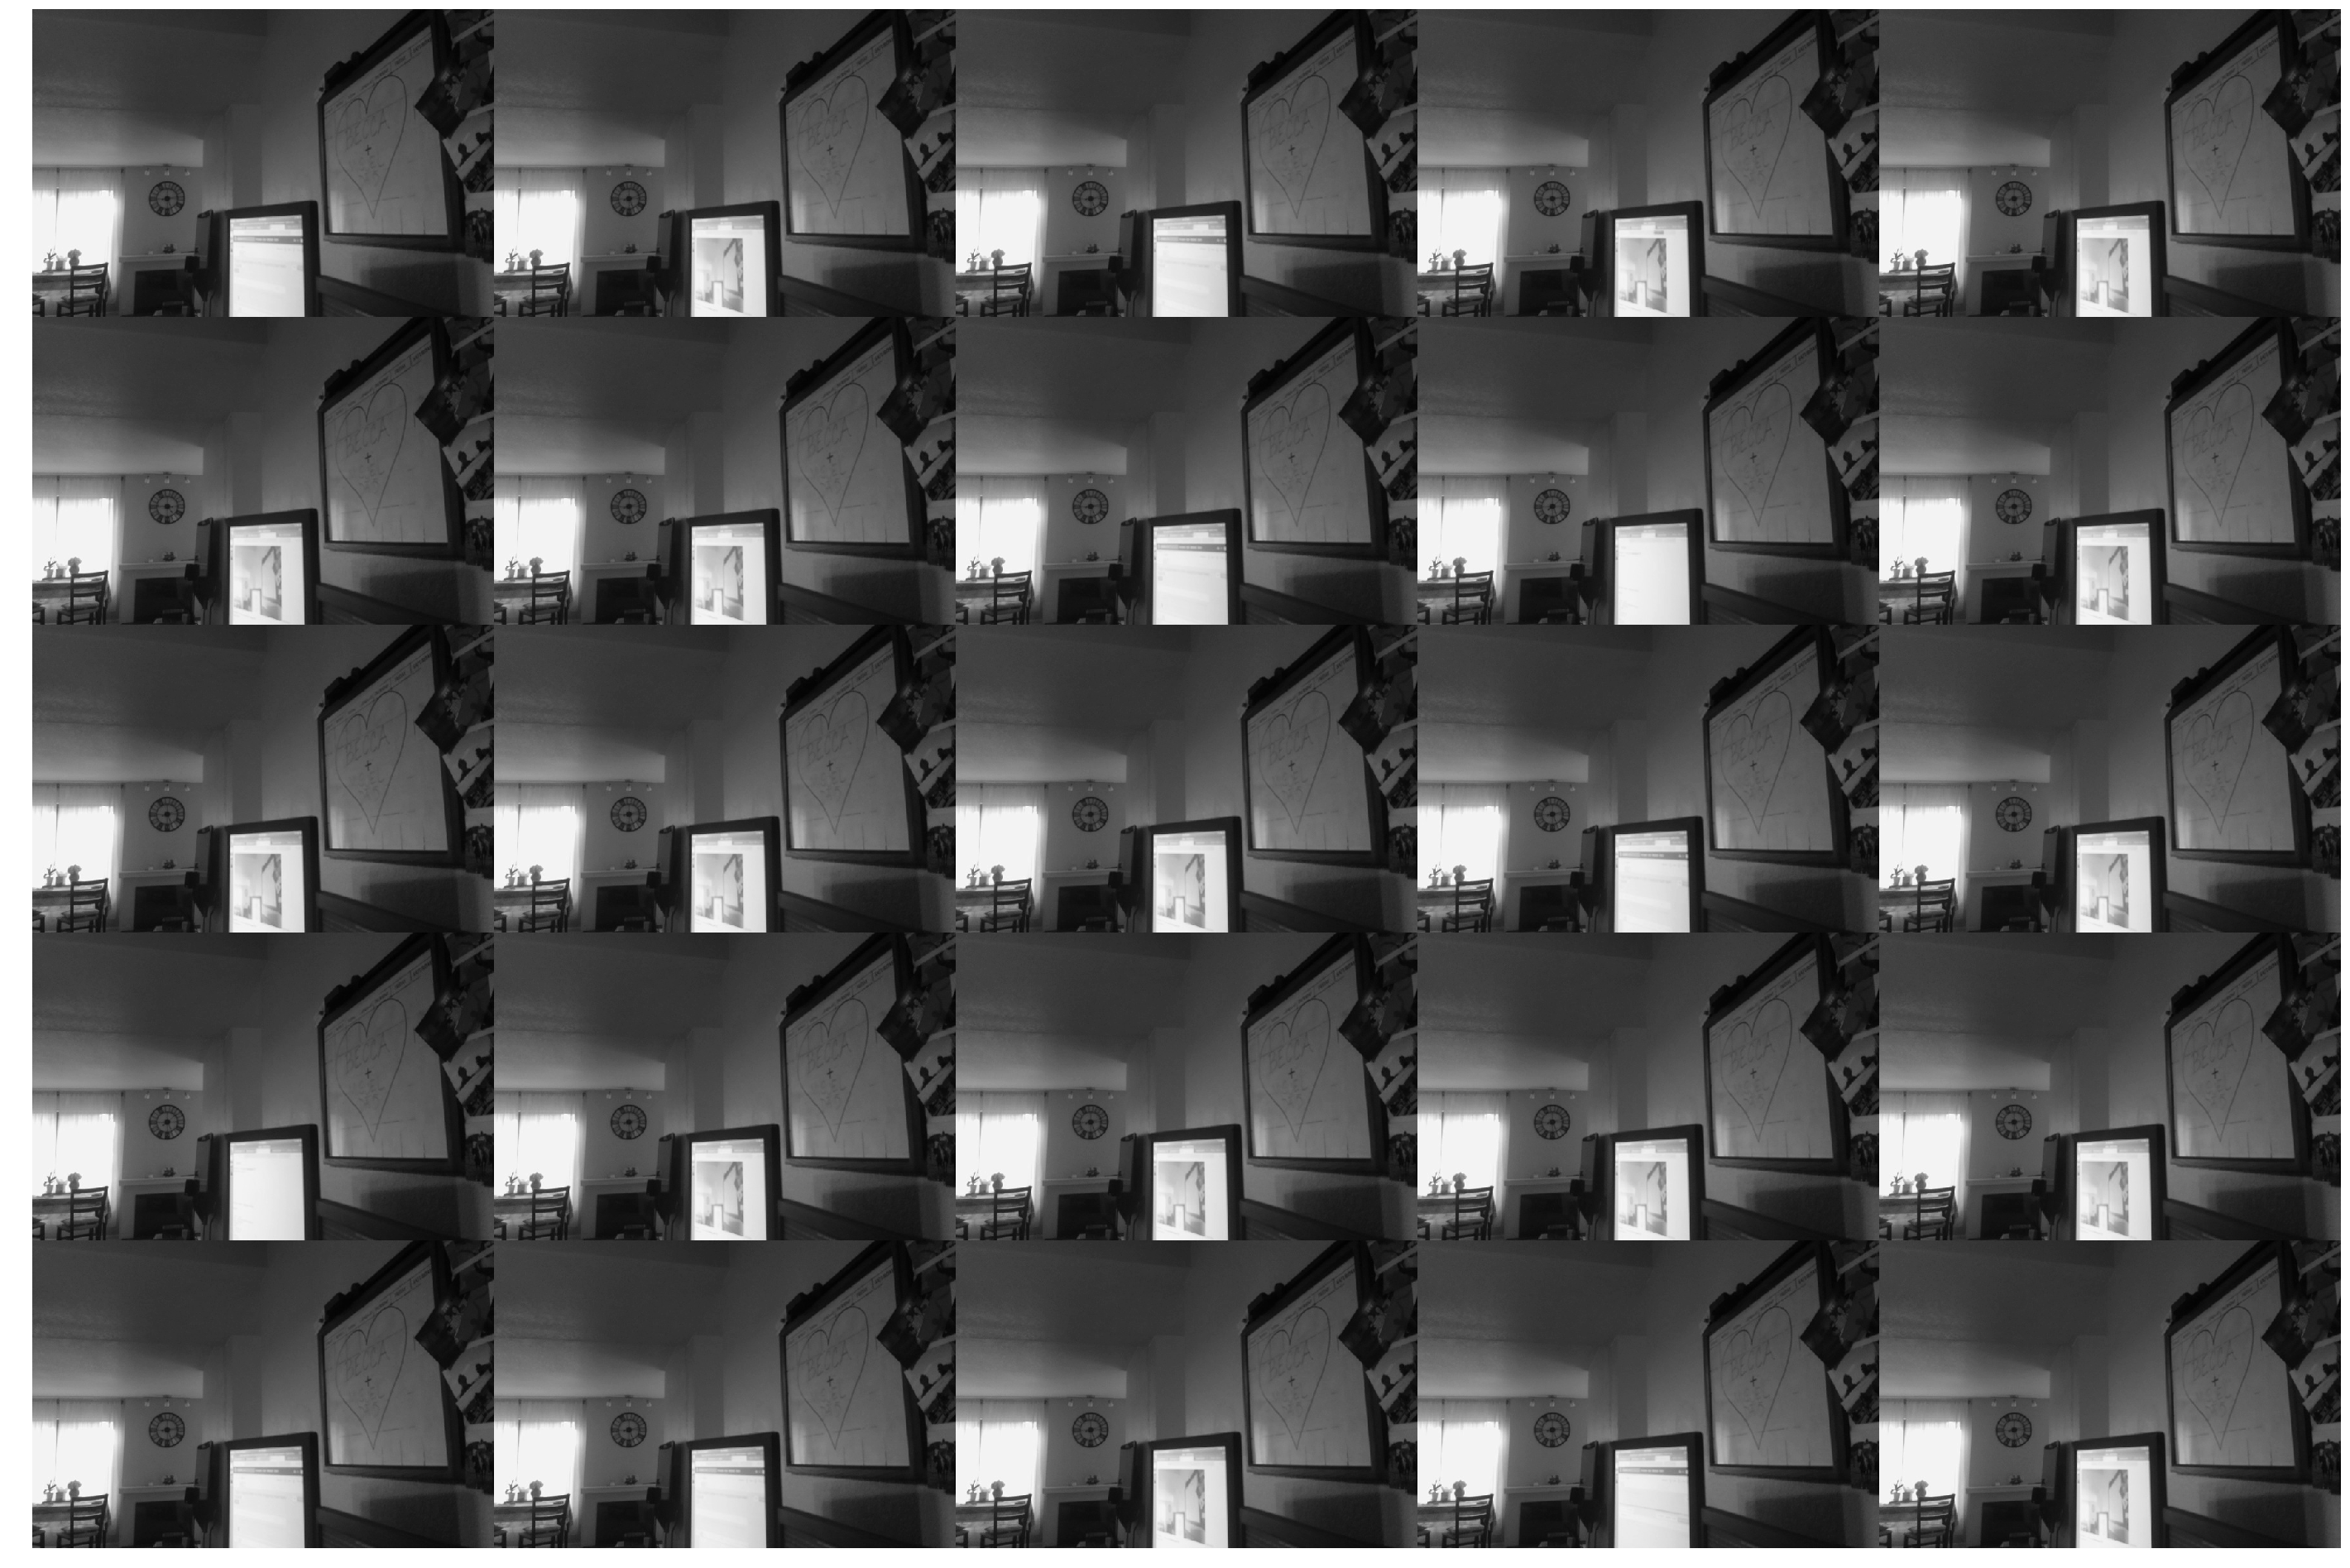

In [14]:
images = snapshots["image"]
shape = images.head(n=1).values[0].shape
images_per_row = 5
rows = 5
samples = images.sample(n=5*rows).values

plot_images(samples, shape, images_per_row=images_per_row)

In [15]:
snapshots.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 812 entries, 430 to 291
Data columns (total 19 columns):
drive.orientation                   812 non-null int64
drive.throttle                      812 non-null int64
imagePath                           812 non-null object
start                               812 non-null int64
timeWindow                          812 non-null int64
trigger                             812 non-null object
uuid                                812 non-null object
vehicle.backLeft.command.value      812 non-null int64
vehicle.backLeft.speed              812 non-null int64
vehicle.backRight.command.value     812 non-null int64
vehicle.backRight.speed             812 non-null int64
vehicle.frontLeft.command.value     812 non-null int64
vehicle.frontLeft.speed             812 non-null int64
vehicle.frontRight.command.value    812 non-null int64
vehicle.frontRight.speed            812 non-null int64
image                               812 non-null object
quadrant 

In [16]:
snapshots.describe()

drive.orientation  drive.throttle         start  timeWindow  \
count         812.000000      812.000000  8.120000e+02  812.000000   
mean          126.724138       13.657635  1.525652e+12   52.615764   
std            81.729805       49.430628  4.020661e+05   18.243798   
min            30.000000        0.000000  1.525650e+12    0.000000   
25%            90.000000        0.000000  1.525652e+12   46.000000   
50%            90.000000        0.000000  1.525652e+12   52.000000   
75%           105.000000        0.000000  1.525652e+12   60.000000   
max           330.000000      255.000000  1.525652e+12  116.000000   

       vehicle.backLeft.command.value  vehicle.backLeft.speed  \
count                      812.000000              812.000000   
mean                         1.588670               13.500000   
std                          0.983599               48.860846   
min                          1.000000                0.000000   
25%                          1.000000                0.000000   
50%                          1.000000                0.000000   
75%                          2.000000                0.000000   
max                          4.000000              255.000000   

       vehicle.backRight.command.value  vehicle.backRight.speed  \
count                       812.000000               812.000000   
mean                          1.588670                 9.160099   
std                           0.983599                34.729378   
min                           1.000000                 0.000000   
25%                           1.000000                 0.000000   
50%                           1.000000                 0.000000   
75%                           2.000000                 0.000000   
max                           4.000000               255.000000   

       vehicle.frontLeft.command.value  vehicle.frontLeft.speed  \
count                       812.000000               812.000000   
mean                          1.588670                13.500000   
std                           0.983599                48.860846   
min                           1.000000                 0.000000   
25%                           1.000000                 0.000000   
50%                           1.000000                 0.000000   
75%                           2.000000                 0.000000   
max                           4.000000               255.000000   

       vehicle.frontRight.command.value  vehicle.frontRight.speed    quadrant  
count                        812.000000                812.000000  812.000000  
mean                           1.588670                  9.160099    2.328818  
std                            0.983599                 34.729378    0.891946  
min                            1.000000                  0.000000    1.000000  
25%                            1.000000                  0.000000    2.000000  
50%                            1.000000                  0.000000    2.000000  
75%                            2.000000                  0.000000    2.000000  
max                            4.000000                255.000000    4.000000

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5311483860>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f531146c160>]], dtype=object)

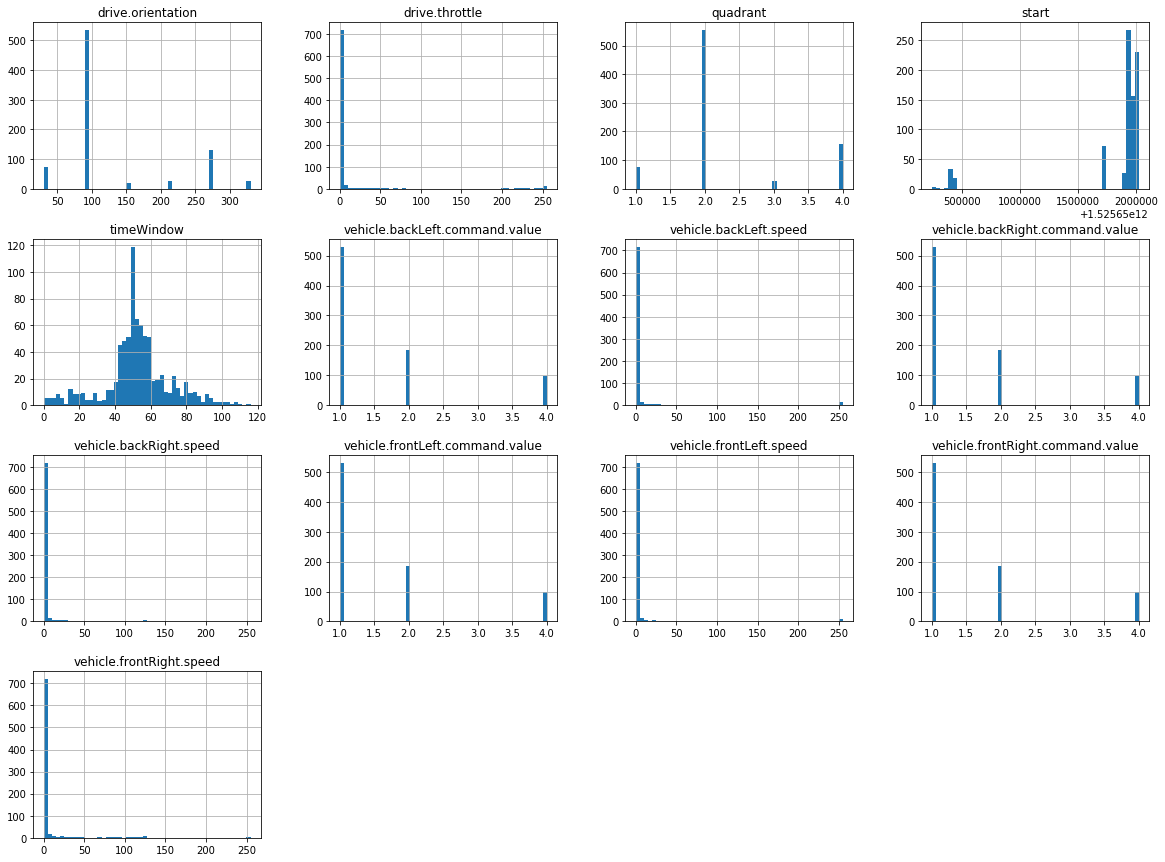

In [17]:
snapshots.hist(bins=50, figsize=(20, 15))

In [18]:
corr_matrix = snapshots.corr()
corr_matrix["drive.orientation"].sort_values(ascending=False)

drive.orientation                   1.000000
quadrant                            0.979938
vehicle.frontRight.command.value    0.239676
vehicle.frontLeft.command.value     0.239676
vehicle.backRight.command.value     0.239676
vehicle.backLeft.command.value      0.239676
start                               0.206758
timeWindow                         -0.060833
vehicle.frontRight.speed           -0.130391
vehicle.backRight.speed            -0.130391
drive.throttle                     -0.192336
vehicle.frontLeft.speed            -0.195499
vehicle.backLeft.speed             -0.195499
Name: drive.orientation, dtype: float64

# Train a model

In [19]:
def prepare_data(data):
    X = data["image"].apply(lambda image: image_features(image)).values
    y = data["drive.orientation"].values
    
    return X, y

In [20]:
X, y = prepare_data(snapshots)
X_test, y_test = prepare_data(test_set)

In [21]:
from sklearn.base import BaseEstimator, TransformerMixin

# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [28]:
def rmse(model):
    y_predictions = tree_reg.predict(X_test)
    mse = mean_squared_error(y_test, y_predictions)
    
    return numpy.sqrt(mse)

In [23]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=42,
           splitter='best')

In [29]:
rmse(tree_reg)

58.757561048703828

In [30]:
from sklearn.externals import joblib

joblib.dump(tree_reg, "tree_reg.pkl") # DIFF

tree_reg_loaded = joblib.load("tree_reg.pkl") # DIFF

In [31]:
from sklearn.ensemble import RandomForestRegressor

rnd_reg = RandomForestRegressor(n_estimators=500, max_leaf_nodes=256, n_jobs=-1, random_state=42)
rnd_reg.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=256,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=-1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

In [32]:
rmse(rnd_reg)

58.757561048703828

In [33]:
from sklearn.externals import joblib

joblib.dump(tree_reg, "rnd_reg.pkl") # DIFF

rnd_reg_loaded = joblib.load("rnd_reg.pkl") # DIFF

In [34]:
def plot_importance(data):
    image = data.reshape(shape)
    pyplot.imshow(image, cmap=cm.hot, interpolation="nearest")
    pyplot.axis("off")
    
    cbar = pyplot.colorbar(ticks=[data.min(), data.max()])
    cbar.ax.set_yticklabels(['Not important', 'Very important'])

    pyplot.show()

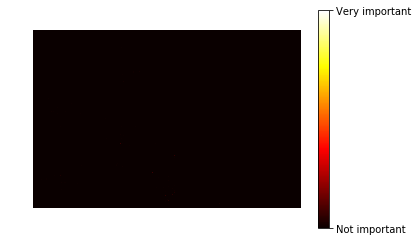

In [35]:
plot_importance(rnd_reg.feature_importances_)